# ECE 204: Final Assessment Remote Portion - Air Quality

## Report by: Vedant Grover 

### Date: 12/15/2023

### Import Statements

In [120]:
# Import Statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import stats
from pandas.plotting import parallel_coordinates
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize 
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_curve

### Data Importation

In [121]:
# Data Importation

df = pd.read_csv('air_quality.csv', parse_dates = True, index_col = 0)
df.head()

,RADON_pCi/L,TEMP_F,HUMIDITY,PRESSURE_hPa,CO2_ppm,VOC_ppb,High_CO2
recorded,,,,,,,
2021-02-01 00:00:09,1.22,63.39,39.0,989,560,75.0,No
2021-02-01 01:00:09,1.19,62.67,38.5,989,548,91.0,No
2021-02-01 02:00:09,1.19,63.55,38.0,989,593,110.0,No
2021-02-01 03:00:09,1.22,63.07,37.5,989,573,110.0,No
2021-02-01 04:00:09,1.24,62.33,37.5,990,555,138.0,No


### Initial Exploration

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8734 entries, 2021-02-01 00:00:09 to 2022-01-31 23:22:07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RADON_pCi/L   8734 non-null   float64
 1   TEMP_F        8734 non-null   float64
 2   HUMIDITY      8734 non-null   float64
 3   PRESSURE_hPa  8734 non-null   int64  
 4   CO2_ppm       8734 non-null   int64  
 5   VOC_ppb       8734 non-null   float64
 6   High_CO2      8734 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 545.9+ KB


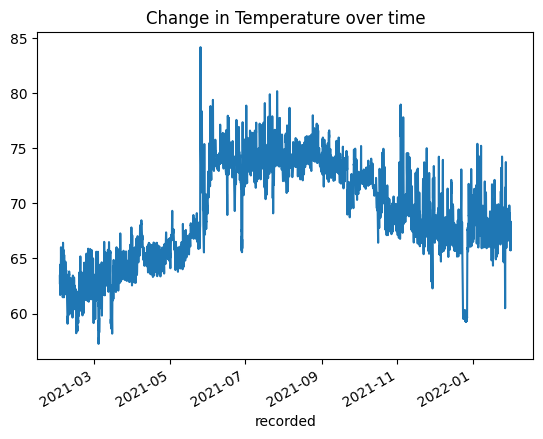

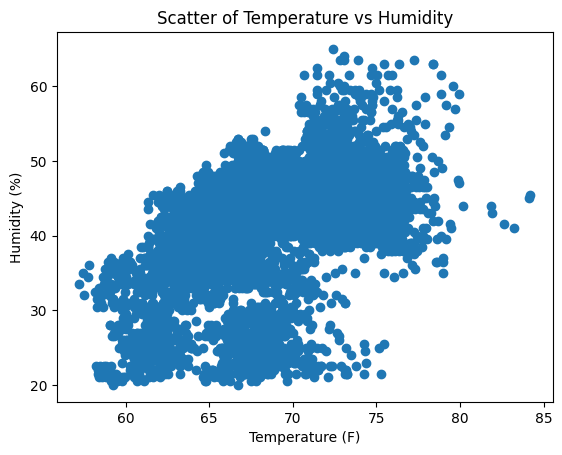

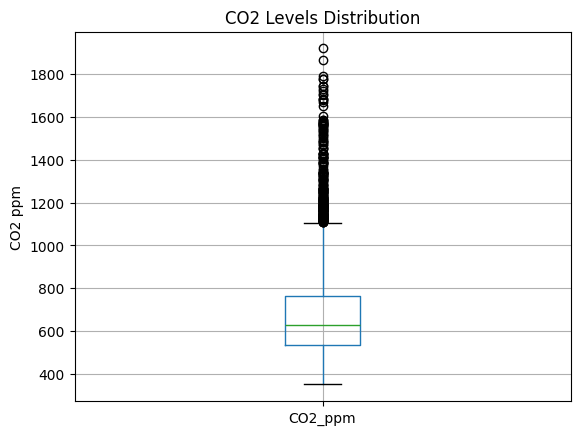

In [122]:
# Initial Exploration

# Getting overviews of the dataset
df.describe()
df.info()

# Time Series Plot, Visualizing how the temperature changed over time
df['TEMP_F'].plot(kind = 'line', title = 'Change in Temperature over time')
plt.show()

# Scatter Plot, examining the relationship between Temperature and Humidity
plt.scatter(df['TEMP_F'], df['HUMIDITY'])
plt.title('Scatter of Temperature vs Humidity')
plt.ylabel('Humidity (%)')
plt.xlabel('Temperature (F)')
plt.show()

# Box Plot, showing any outliers in the dataset
df.boxplot(column = 'CO2_ppm')
plt.title('CO2 Levels Distribution')
plt.ylabel('CO2 ppm')
plt.show()

### Data Pre-processing and cleaning: justification & explanation

The first step would be to check and detect any missing values, and then handle them appropriately. Missing data can significantly affect and distort analysis, however in this case after running a test to see how many columns had missing values, it turns out there are no missing values in any columns. Each column has complete data without any null entries or gaps. 

The next step to take is detecting and handling any outliers as they can affect results by skewing the data. By using the zscore function below, we can find any values that are significantly lower or higher than the mean. 3 was the number chosen, meaning any value more than 3 standard deviations away from the mean is considered an outlier and can be removed. By checking the .info() method before and after running the line, we can see that the total number of entries reduced from 8734 to 8322. 

Lastly, I will transform the 'High_CO2' column into the numerical format, mapping all 'Yes' and 'No' values to '1' and '0' respectively. This makes it easier for processing and analysis. 

### Data Pre-processing and cleaning: Code

In [123]:
# Data Pre-processing and cleaning

# Detecting any missing values
missing_vals = df.isnull().sum()
missing_vals

# Handling outliers
df = df[(np.abs(stats.zscore(df.select_dtypes(include = [np.number]))) < 3).all(axis = 1)]
df.info()

# Changing the 'High_CO2' Column to 1s and 0s
df['High_CO2'] = df['High_CO2'].map({'Yes': 1, 'No': 0})
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8322 entries, 2021-02-01 00:00:09 to 2022-01-31 23:22:07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RADON_pCi/L   8322 non-null   float64
 1   TEMP_F        8322 non-null   float64
 2   HUMIDITY      8322 non-null   float64
 3   PRESSURE_hPa  8322 non-null   int64  
 4   CO2_ppm       8322 non-null   int64  
 5   VOC_ppb       8322 non-null   float64
 6   High_CO2      8322 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 520.1+ KB


,RADON_pCi/L,TEMP_F,HUMIDITY,PRESSURE_hPa,CO2_ppm,VOC_ppb,High_CO2
recorded,,,,,,,
2021-02-01 00:00:09,1.22,63.39,39.0,989,560,75.0,0
2021-02-01 01:00:09,1.19,62.67,38.5,989,548,91.0,0
2021-02-01 02:00:09,1.19,63.55,38.0,989,593,110.0,0
2021-02-01 03:00:09,1.22,63.07,37.5,989,573,110.0,0
2021-02-01 04:00:09,1.24,62.33,37.5,990,555,138.0,0


### Descriptive Analysis: Written Analysis

I chose clustering as the tool for this descriptive analysis. By using K-Means clustering, I am aiming to uncover natural groupings and patterns in the air quality dataset based on similarities across different features. Based on the selected features, we can see visually how data points are grouped into clusters. 

First, I have a scatter plot of the temperature and CO2 levels, it shows the distribution of data points based on the columns 'TEMP_F' and 'CO2_ppm', it shows the relationship between CO2 levels and temperature, and how they group together naturally. I also have a box plot for humidity distribution in each cluster, this helps us understand if distinct humidity characteristics are exhibited due to different clusters. Finally, I also have a parallel coordinates plot, allowing us to compare the distribution of temperature, humidity and CO2 levels across the clusters. This chart can show the behavior of multiple features across the clusters, showcasing how the features differ between clusters. 

I think these charts give a good view of the clustering results, showing the relationship between different air quality parameters within each cluster and identifying distinct patterns in the data, which was my aim. 

### Descriptive Analysis: Code

C:\Users\16089\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


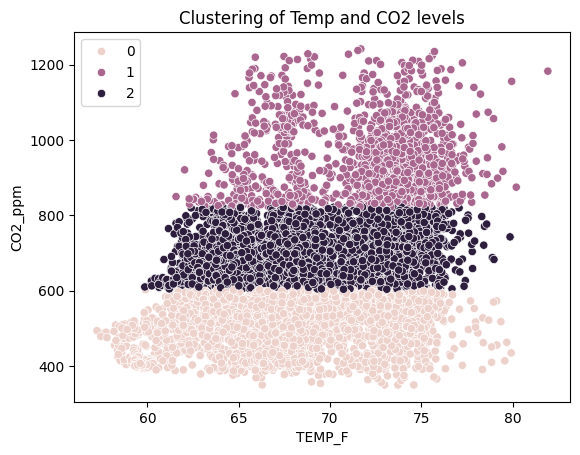

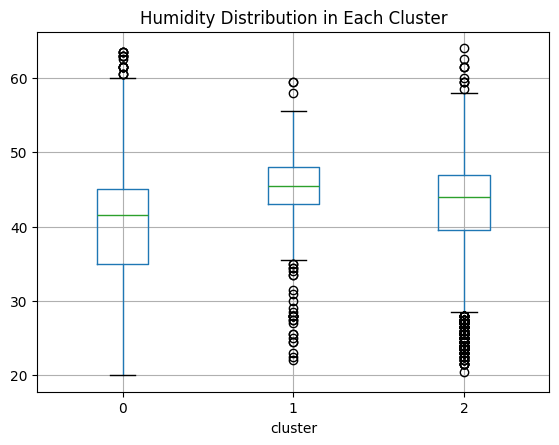

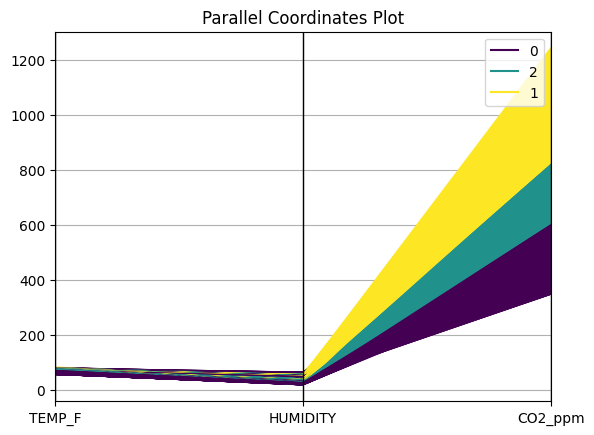

In [124]:
# Descriptive Analysis

# Clustering
# Scatter Plot of clusters
cluster_data = df[['TEMP_F', 'CO2_ppm']]
kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit_predict(cluster_data)

sns.scatterplot(x = 'TEMP_F', y = 'CO2_ppm', data = cluster_data, hue = clusters)
plt.title('Clustering of Temp and CO2 levels')
plt.show()

# Box plot for each cluster 
df['cluster'] = clusters
df.boxplot(by = 'cluster', column = 'HUMIDITY')
plt.title('Humidity Distribution in Each Cluster')
plt.suptitle('')
plt.show()

# Parallel coordinates plot
parallel_coordinates(df[['TEMP_F', 'HUMIDITY', 'CO2_ppm', 'cluster']], 'cluster', colormap = 'viridis')
plt.title('Parallel Coordinates Plot')
plt.show()

### Predictive Analysis: Question and Written Analysis

Question:
Can we classify the air quality as 'Bad', 'Moderate', or 'Good' based on CO2 and VOC levels?

Written Analysis:
I came up with this question to address after some initial testing and found this to be quite an interesting one to explore further. There are many steps to take to fully explore and address this question, including preparing and splitting the data, training the model, and finally evaluating and visualizing it. 

I have used K-Nearest Neighbors classifier to analyze this air quality dataset and help address this question. In order to construct a KNN model for classifying air quality based on the CO2 and VOC levels, I first transformed the CO2 and VOC measurements into a categorical variable that'll represent the different air quality classes, Good, Moderate, and Bad. I chose KNN due to its simplicity in handling multi-class classification problems. I performed a train-test split to validate the ability of the model to generalize unseen data. The 3 categories were made using quantile-based thresholds, which ensured equal distribution of data across classes.

### Predictive Analysis: Code

#### Data Preparation and Split
I need to prepare the data before getting to train the KNN classifier, this step involves making a new categorical label for air quality based on domain knowledge or statistical rules such as quantiles for CO2 and VOC levels. 

I also need to split the dataset into training and test sets

In [125]:
# Predictive Analysis

# Preparing the data, creating a new categorical label
co2_quantiles = df['CO2_ppm'].quantile([0.33, 0.66])
voc_quantiles = df['VOC_ppb'].quantile([0.33, 0.66])

def classify_air_quality(row):
    if row['VOC_ppb'] <= voc_quantiles.iloc[0] and row['CO2_ppm'] <= co2_quantiles.iloc[0]:
        return 'Good'
    elif row['VOC_ppb'] <= voc_quantiles.iloc[1] and row['CO2_ppm'] <= co2_quantiles.iloc[1]:
        return 'Moderate'
    else:
        return 'Bad'

# Applying the function and encoding the categorical label
df['Air_Quality'] = df.apply(classify_air_quality, axis = 1)
le = LabelEncoder()
df['Air_Quality_Label'] = le.fit_transform(df['Air_Quality'])

X = df[['VOC_ppb', 'CO2_ppm']]
y = df['Air_Quality_Label']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Model Training
Now, I need to initialize the KNN model and find the optimal number of neighbours for the classifier by using cross-validation

In [ ]:
# Initializing KNN classifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 50))}
grid_search = GridSearchCV(knn, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print(f"parameters: {grid_search.best_params_}")

#### Model Evaluation
The next step is to evaluate the KNN classifier and see how well it predicts by using the test data.

I've also chosen to create a confusion matrix to help us understand the classification performance for each category, showing how many samples were correctly predicted. 

In [ ]:
# Predictions: Classification Report
y_prediction = best_knn.predict(X_test)
print(classification_report(y_test, y_prediction))

# Confusion matrix
my_cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize = (8, 6))
sns.heatmap(my_cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Air Quality Classification Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

#### Model Visualization: Charts
The next step is for me to show visualizations and charts depicting the model performance. These visuals can help show how the model performs across the different classes of air quality. 

In addition to the confusion matrix, I am choosing to create a Multi-class ROC Curve to showcase the model's ability to classify each class against all others. I have also chosen to make a precision-recall curve to focus on the performance of the classifier on the positive class, and a feature importance plot to assess how predictive each feature is. KNN is a non-parametric method so it doesn't inherently provide feature importance scores. 

In [ ]:
# Predicting probabilities
y_binarized = label_binarize(y_test, classes = [0, 1, 2])
n_classes = y_binarized.shape[1]
y_score = best_knn.predict_proba(X_test)

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Cyclying through color choices for each class
plt.figure(figsize = (8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, 
             label = 'Class {0} ROC Curve (area = {1:0.2f})'.format(i, roc_auc[i]))
# Plotting it
plt.plot([0, 1], [0, 1], 'k--', lw = 2)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = "lower right")
plt.title('Air Quality Classification Model Multi-Class ROC Curve')
plt.show()

# Feature Importance Plot
perm_imp = permutation_importance(best_knn, X_test, y_test)
sorted_idx = perm_imp.importances_mean.argsort()
plt.barh(df.columns[sorted_idx], perm_imp.importances_mean[sorted_idx])
plt.title('Feature Importance Plot')
plt.xlabel('Permutation Importance')
plt.show()

# Precision-recall curves
y_binarized = label_binarize(y_test, classes = [0, 1, 2])
n_classes = y_binarized.shape[1]
y_score = best_knn.predict_proba(X_test)
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.figure(figsize = (10, 8))

# Computing plot curve
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_binarized[:, i], y_score[:, i])
    plt.plot(recall, precision, color = color, lw = 2, label = 'Class {0} Precision-Recall Curve'.format(i))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc = "upper right")
plt.title('Precision-Recall Curve for every class')
plt.show()

### Conclusion
I would say overall, my analysis of this air quality dataset using a KNN classifier has yielded successful results. As shown some of my numerous evaluation metrics, there is a high number of correct classifications with few misclassifications. The confusion matrix showcased this, most instances were correctly classified. The feature importance plot I created indicated to us that 'RADON_pCi/L' was a more significant predictor than 'TEMP_F' for our model. This could mean that radon levels have a stronger relationship with the classes defined for air quality. 

On the other hand, the ROC and Precision-Recall curves in particular gave perfect scores which suggested flawless classification ability from the model. These perfect scores do raise some questions and could prompt a closer examination on possible data leakage, issues with the process, overfitting etc. So even though the overall analysis was a success there are a couple of things that could be examined a little further. 